# Mathematical Foundations of Deep Neural Network

## Homework 5

### 2017-11362 박건도

### Problem 1: *Implementing backprop for MLP*.

In [1]:
import torch
from torch import nn

def sigma(x):
    return torch.sigmoid(x)
def sigma_prime(x):
    return sigma(x)*(1-sigma(x))


torch.manual_seed(0)
L = 6
X_data = torch.rand(4, 1)
Y_data = torch.rand(1, 1)

A_list,b_list = [],[]
for _ in range(L-1):
    A_list.append(torch.rand(4, 4))
    b_list.append(torch.rand(4, 1))
A_list.append(torch.rand(1, 4))
b_list.append(torch.rand(1, 1))

# Option 1: directly use PyTorch's autograd feature
for A in A_list:
    A.requires_grad = True
for b in b_list:
    b.requires_grad = True
    
y = X_data
for ell in range(L):
    S = sigma if ell<L-1 else lambda x: x
    y = S(A_list[ell]@y+b_list[ell])
    
# backward pass in pytorch
loss=torch.square(y-Y_data)/2
loss.backward()
print("autograd")
print(A_list[0].grad)

autograd
tensor([[2.3943e-05, 3.7064e-05, 4.2687e-06, 6.3700e-06],
        [3.4104e-05, 5.2794e-05, 6.0804e-06, 9.0735e-06],
        [2.4438e-05, 3.7831e-05, 4.3571e-06, 6.5019e-06],
        [2.0187e-05, 3.1250e-05, 3.5991e-06, 5.3707e-06]])


In [2]:
torch.manual_seed(0)
L = 6
X_data = torch.rand(4, 1)
Y_data = torch.rand(1, 1)

A_list,b_list = [],[]
for _ in range(L-1):
    A_list.append(torch.rand(4, 4))
    b_list.append(torch.rand(4, 1))
A_list.append(torch.rand(1, 4))
b_list.append(torch.rand(1, 1))

# Option 3: implement backprop yourself
y_list = [X_data]
y = X_data
for ell in range(L):
    S = sigma if ell<L-1 else lambda x: x
    y = S(A_list[ell]@y+b_list[ell])
    y_list.append(y)
    
dA_list = []
db_list = []
dy = y-Y_data  # dloss/dy_L
for ell in reversed(range(L)):
    S = sigma_prime if ell<L-1 else lambda x: torch.ones(x.shape)
    A, b, y = A_list[ell], b_list[ell], y_list[ell]
    dd = torch.diag(S(A @ y + b).view(-1))
    db = dy @ dd     # dloss/db_ell
    dA = (y @ db).T  # dloss/dA_ell
    dy = db @ A      # dloss/dy_{ell-1}

    dA_list.insert(0, dA)
    db_list.insert(0, db)
print("backprop")
print(dA_list[0])

backprop
tensor([[2.3943e-05, 3.7064e-05, 4.2687e-06, 6.3700e-06],
        [3.4104e-05, 5.2794e-05, 6.0804e-06, 9.0735e-06],
        [2.4438e-05, 3.7831e-05, 4.3571e-06, 6.5019e-06],
        [2.0187e-05, 3.1250e-05, 3.5991e-06, 5.3707e-06]])


### Problem 2: *Vanishing gradients.*

![prob2](prob2.png)

### Problem 3. *Two forms of momentum SGD*

![prob3](prob3.png)

### Problem 4: *Receptive field*

![prob4](prob4.png)

### Problem 5: *bottleneck convolution*

![prob5](prob5.png)

### Problem 6: *label - memorization*

In [3]:
import torch
import torch.nn as nn
import time

# Make sure to use only 10% of the available MNIST data.
# Otherwise, experiment will take quite long (around 90 minutes).

from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

train_set = datasets.MNIST('./mnist_data', train=True, transform = transforms.ToTensor(), download=True)
# 6,000 train set
idx = list(range(6000))
train_set.data = train_set.data[idx]
# randomized label
train_set.targets = torch.randint(0,9,(6000,))

# (Modified version of AlexNet)
class AlexNet(nn.Module):
    def __init__(self, num_class=10):
        super(AlexNet, self).__init__()

        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, kernel_size=3),
            nn.ReLU(inplace=True)
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.fc_layer1 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(6400, 800),
            nn.ReLU(inplace=True),
            nn.Linear(800, 10)
        )

    def forward(self, x):
        output = self.conv_layer1(x)
        output = self.conv_layer2(output)
        output = self.conv_layer3(output)
        output = torch.flatten(output, 1)
        output = self.fc_layer1(output)
        return output


learning_rate = 0.1
batch_size = 64
epochs = 150

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=train_set, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet().to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Train_Accuracy = []
Train_Loss = []

tick = time.time()
for epoch in range(150):
    print(f"Epoch {epoch + 1} / {epochs}")
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        loss = loss_function(model(images), labels)
        loss.backward()

        optimizer.step()
    
    # Accuracy & Loss
    with torch.no_grad():
        correct = 0
        for images, labels in test_loader:
            output = model(images.to(device))
            pred = output.max(1, keepdim=True)[1].cpu().view(-1)
            correct += torch.sum(labels == pred)
        Train_Accuracy.append(correct/6000)
        Train_Loss.append(loss.item())

tock = time.time()
print(f"Total training time: {tock - tick}")

/home/zendo/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Epoch 1 / 150
Epoch 2 / 150
Epoch 3 / 150
Epoch 4 / 150
Epoch 5 / 150
Epoch 6 / 150
Epoch 7 / 150
Epoch 8 / 150
Epoch 9 / 150
Epoch 10 / 150
Epoch 11 / 150
Epoch 12 / 150
Epoch 13 / 150
Epoch 14 / 150
Epoch 15 / 150
Epoch 16 / 150
Epoch 17 / 150
Epoch 18 / 150
Epoch 19 / 150
Epoch 20 / 150
Epoch 21 / 150
Epoch 22 / 150
Epoch 23 / 150
Epoch 24 / 150
Epoch 25 / 150
Epoch 26 / 150
Epoch 27 / 150
Epoch 28 / 150
Epoch 29 / 150
Epoch 30 / 150
Epoch 31 / 150
Epoch 32 / 150
Epoch 33 / 150
Epoch 34 / 150
Epoch 35 / 150
Epoch 36 / 150
Epoch 37 / 150
Epoch 38 / 150
Epoch 39 / 150
Epoch 40 / 150
Epoch 41 / 150
Epoch 42 / 150
Epoch 43 / 150
Epoch 44 / 150
Epoch 45 / 150
Epoch 46 / 150
Epoch 47 / 150
Epoch 48 / 150
Epoch 49 / 150
Epoch 50 / 150
Epoch 51 / 150
Epoch 52 / 150
Epoch 53 / 150
Epoch 54 / 150
Epoch 55 / 150
Epoch 56 / 150
Epoch 57 / 150
Epoch 58 / 150
Epoch 59 / 150
Epoch 60 / 150
Epoch 61 / 150
Epoch 62 / 150
Epoch 63 / 150
Epoch 64 / 150
Epoch 65 / 150
Epoch 66 / 150
Epoch 67 / 150
Epoc

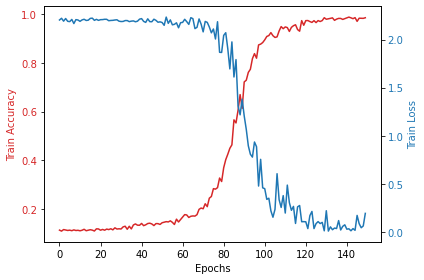

In [4]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Train Accuracy', color=color)
ax1.plot(range(150), Train_Accuracy, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Train Loss', color=color)  # we already handled the x-label with ax1
ax2.plot(range(150), Train_Loss, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()